In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## Exploring Fake News

In [ ]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [ ]:
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [ ]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

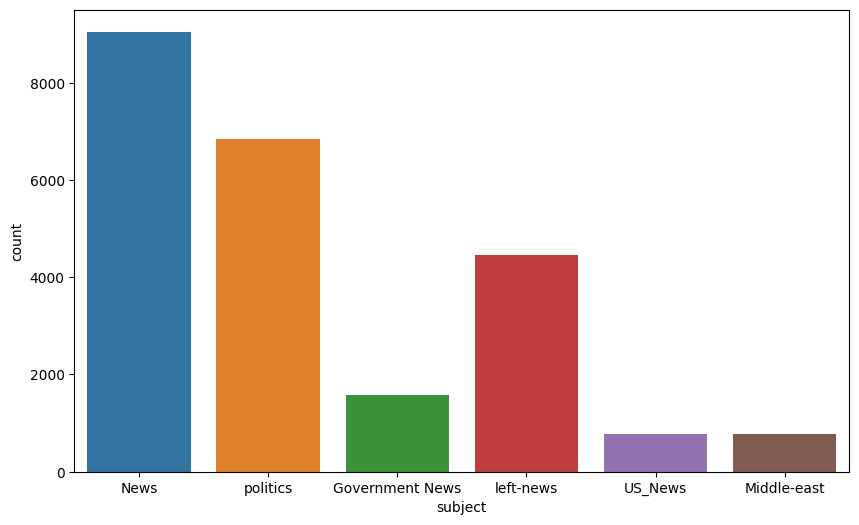

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x= 'subject',data=fake)

## Wordcloud

In [ ]:
text = ' '.join(fake['text'].tolist())

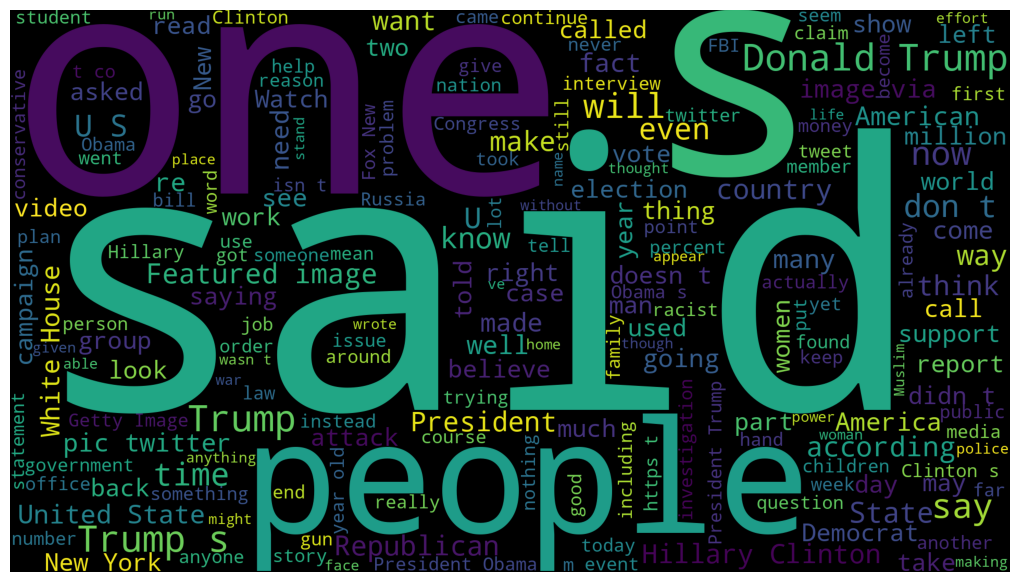

In [ ]:
wordcloud = WordCloud(width = 1920, height = 1080).generate(text)
fig = plt.figure(figsize =(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Exploring Real News

In [ ]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [ ]:
text = ' '.join(fake['text'].tolist())

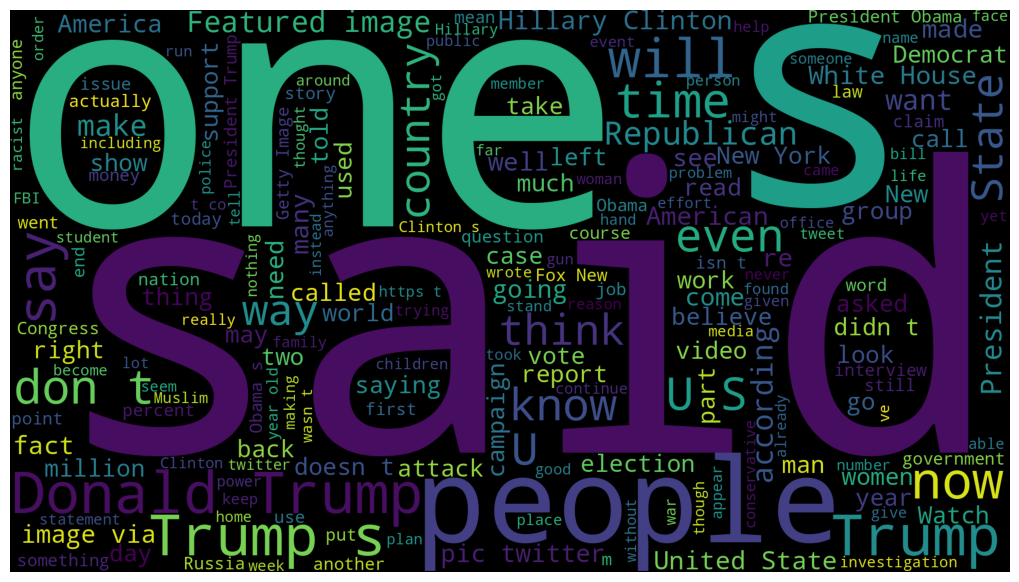

In [ ]:
wordcloud = WordCloud(width = 1920, height = 1080).generate(text)
fig = plt.figure(figsize =(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Difference in Text

Real news seems to have source of publication which is not present in fake news set.

Looking at the data:


*   most of text contains reuters information such as "**WASHINGTON(Reuters)**"
*   some texts are tweets from twitter
*   few text do not contain any publication info

## Cleaning Data
Removing reuters or twitter tweet information from the text


*   text can be splitted only once at "-" which is always present after mentioning source of publication, this gives us publication part and text part.
*   If we do not get text part, that means publication detail wasn't given for that record


*   The twitter tweet always have the same source, a long text of max 259 characters






In [ ]:
real.sample(5)

title  \
9219   Judge issues final order upholding Alabama sam...   
18471  Australia to fit warships with anti-missile de...   
807    Senator Paul suffers five broken ribs after as...   
3557   U.S. lawmakers to fight massive Trump Saudi ar...   
8008   Trump tweets he raised $13 million in 24 hours...   

                                                    text       subject  \
9219   (Reuters) - A federal judge in Alabama has iss...  politicsNews   
18471  SYDNEY (Reuters) - Australian Prime Minister M...     worldnews   
807    (Reuters) - U.S. Senator Rand Paul’s return to...  politicsNews   
3557   WASHINGTON (Reuters) - U.S. lawmakers introduc...  politicsNews   
8008   WASHINGTON (Reuters) - Republican Party presid...  politicsNews   

                      date  
9219         June 8, 2016   
18471     October 2, 2017   
807      November 5, 2017   
3557         May 25, 2017   
8008   September 27, 2016

In [ ]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
    try:
        record = row.split('-', maxsplit = 1)
        record[1]

        assert(len(record[0]) < 120)
    except:
        unknown_publishers.append(index)

In [ ]:
len(unknown_publishers)

222

In [ ]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [ ]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        publisher.append('Unknown')

    else:
        record = row.split('-', maxsplit = 1)
        publisher.append(record[0].strip())
        tmp_text.append(record[1].strip())

In [ ]:
real['publisher']  = publisher
real['text'] = tmp_text

In [ ]:
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  The head of a conservative Republican faction ...  politicsNews   
1  Transgender people will be allowed for the fir...  politicsNews   
2  The special counsel investigation of links bet...  politicsNews   
3  Trump campaign adviser George Papadopoulos tol...  politicsNews   
4  President Donald Trump called on the U.S. Post...  politicsNews   

                 date                     publisher  
0  December 31, 2017           WASHINGTON (Reuters)  
1  December 29, 2017           WASHINGTON (Reuters)  
2  December 31, 2017           WASHINGTON (Reuters)  
3  December 30, 2017           WASHINGTON (Reuters)  
4  December 29, 2017   SEATTLE/WASHINGTON (Reuters)

In [ ]:
real.shape

(21417, 5)

In [ ]:
empty_fake_index = [index for index, text in enumerate(fake.text.tolist()) if str(text).strip() == ""]

In [ ]:
fake.iloc[empty_fake_index]

title text    subject  \
10923  TAKE OUR POLL: Who Do You Think President Trum...        politics   
11041  Joe Scarborough BERATES Mika Brzezinski Over “...        politics   
11190  WATCH TUCKER CARLSON Scorch Sanctuary City May...        politics   
11225  MAYOR OF SANCTUARY CITY: Trump Trying To Make ...        politics   
11236  SHOCKER: Public School Turns Computer Lab Into...        politics   
...                                                  ...  ...        ...   
21816  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...       left-news   
21826  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...       left-news   
21827  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...       left-news   
21857  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...       left-news   
21873  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...       left-news   

               date  
10923  May 10, 2017  
11041  Apr 26, 2017  
11190   Apr 6, 2017  
11225   Apr 2, 2017  
11236   Apr 1, 2017  
...             ...  
21816  Apr 27, 2015  
21826  Apr 25, 2015  
21827  Apr 25, 2015  
21857  Apr 14, 2015  
21873  Apr 12, 2015  

[630 rows x 4 columns]

In [ ]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [ ]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

##Preprocessing Text

In [ ]:
real['class'] = 1
fake['class'] = 0

In [ ]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [ ]:
real = real[['text', 'class']]

In [ ]:
fake = fake[['text', 'class']]

In [ ]:
data = real.append(fake, ignore_index = True)

<ipython-input-34-1e131b94b4a5>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = real.append(fake, ignore_index = True)


In [ ]:
data.sample(5)

text  class
13738  israel pushes on with law seen protecting pm u...      1
15920  grief-stricken families of japanese abducted b...      1
5917   under fire, uk's may criticizes trump curb on ...      1
12908  malaysian pm najib urges muslims to strongly o...      1
3270   factbox: trump on twitter (june 9) - comey, do...      1

In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 15.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
2023-11-20 13:45:34.095555: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 13:45:34.095615: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register f

In [ ]:
import preprocess_kgptalkie as ps

In [ ]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [ ]:
data.head()

text  class
0  as us budget fight looms republicans flip thei...      1
1  us military to accept transgender recruits on ...      1
2  senior us republican senator let mr mueller do...      1
3  fbi russia probe helped by australian diplomat...      1
4  trump wants postal service to charge much more...      1

##Vectorization -- Word2Vec

In [ ]:
import gensim

In [ ]:
y = data['class'].values

In [ ]:
X = [d.split() for d in data['text'].tolist()]

In [ ]:
type(X[0])

list

In [ ]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [ ]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences = X, vector_size = DIM, window = 10, min_count = 1)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

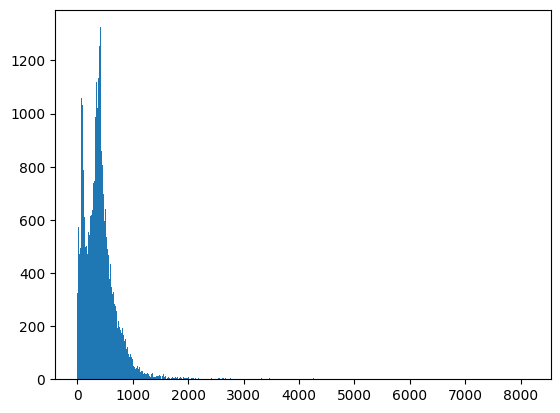

In [ ]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1584

In [ ]:
maxlen = 1000
X = pad_sequences(X, maxlen = maxlen)

In [ ]:
len(X[101])

1000

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))

    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]

    return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model)

In [ ]:
embedding_vectors.shape

(231912, 100)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights = [embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         23191200  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 23308577 (88.92 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 23191200 (88.47 MB)
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train, validation_split = 0.3, epochs = 75)

Epoch 1/75
737/737 [==============================] - 28s 38ms/step - loss: 0.0833 - acc: 0.9699 - val_loss: 0.0414 - val_acc: 0.9864
Epoch 2/75
737/737 [==============================] - 28s 38ms/step - loss: 0.0319 - acc: 0.9893 - val_loss: 0.0394 - val_acc: 0.9877
Epoch 3/75
737/737 [==============================] - 27s 37ms/step - loss: 0.0258 - acc: 0.9916 - val_loss: 0.0444 - val_acc: 0.9840
Epoch 4/75
737/737 [==============================] - 30s 41ms/step - loss: 0.0258 - acc: 0.9919 - val_loss: 0.0273 - val_acc: 0.9912
Epoch 5/75
737/737 [==============================] - 30s 40ms/step - loss: 0.0150 - acc: 0.9955 - val_loss: 0.0538 - val_acc: 0.9802
Epoch 6/75
737/737 [==============================] - 28s 38ms/step - loss: 0.0137 - acc: 0.9955 - val_loss: 0.0245 - val_acc: 0.9913
Epoch 7/75
737/737 [==============================] - 28s 38ms/step - loss: 0.0073 - acc: 0.9980 - val_loss: 0.0222 - val_acc: 0.9917
Epoch 8/75
737/737 [==============================] - 28s 37ms

In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

351/351 [==============================] - 4s 13ms/step


In [ ]:
accuracy_score(y_test, y_pred)

0.9947438752783965

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5844
           1       0.99      1.00      0.99      5381

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
x = ['this is a news']

In [ ]:
X_test

array([[    0,     0,     0, ...,     6,     4,   179],
       [    0,     0,     0, ..., 17349,  2806,   424],
       [    0,     0,     0, ...,     8,    19,   946],
       ...,
       [    0,     0,     0, ...,  1134,  1847,   783],
       [    0,     0,     0, ...,  3577, 29921,   478],
       [    0,     0,     0, ...,     6,     1,   248]], dtype=int32)

In [ ]:
x = ['this is a news']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [ ]:
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 26ms/step


array([[0]])

In [ ]:
x = ['The Kerala government said on Friday that the first-ever Tourism Investors Meet (TIM) organised by it a day ago has significantly boosted the state governments travel and hospitality initiatives in the post-pandemic era. The event resulted in investment offers amounting to Rs 15,116.65 crore in the core sector. This includes a memorandum of understanding that Kerala Tourism signed with Tamara Leisure Experiences for a Rs 250-crore houseboat hotel project, which the Bengaluru-based hospitality group will execute in Alappuzha and Kannur districts, according to a Kerala Tourism release.']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 27ms/step


array([[1]])

In [ ]:
model.predict(x)

1/1 [==============================] - 0s 29ms/step


array([[0.99999964]], dtype=float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/MyDrive/Model/test_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Model/test_model.h5')